In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [3]:
EPOCH = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.005

# Computational device
# Device will be set to GPU if it is available.(you should install valid Pytorch version with CUDA. Otherwise, it will be computed using CPU)
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [4]:
# Fashion MNIST dataset
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

In [5]:
# basic autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential( 
            nn.Linear(28*28, 128), 
            nn.ReLU(),
            nn.Linear(128, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded) 
        return encoded, decoded

In [6]:
# Set for data loader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
SELECT_NORMAL = 2 # Set 2 class as train dataset.
trainset.data = trainset.data[trainset.targets == SELECT_NORMAL]
trainset.targets = trainset.targets[trainset.targets == SELECT_NORMAL]

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

test_label = [2,4,6] # Define actual test class that we use
actual_testdata = torch.isin(testset.targets, torch.tensor(test_label))
testset.data = testset.data[actual_testdata]
testset.targets = testset.targets[actual_testdata]

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = 1,
    shuffle     = False,
    num_workers = 2
)

In [7]:
train_data_size = len(trainset)
test_data_size = len(testset)

print("Train data size:", train_data_size)
print("Test data size:", test_data_size)

Train data size: 6000
Test data size: 3000


In [8]:
# To visualize training procedure
view_data = []
for i in test_label:
    view_data.append(testset.data[testset.targets == i][0].view(28*28))
view_data = torch.Tensor(np.array(view_data))
view_data = view_data.type(torch.FloatTensor)/255.

In [9]:
autoencoder = Autoencoder().to(DEVICE) # generating instance of model that you build.
print(autoencoder) # you can check your model 
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE) # if you want to utilie other optimizer, replace Adam to other.
criterion = nn.MSELoss() # you can change loss function.\

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [10]:
### Ealry stopping
# https://pytorch.org/tutorials/beginner/nn_tutorial.htm

In [11]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE) 

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) 
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() 

[Epoch 1]


KeyboardInterrupt: 

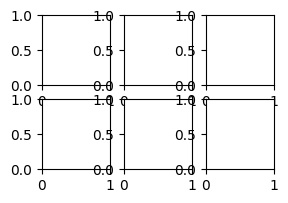

In [12]:
# Training process including visualization
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    f, a = plt.subplots(2, len(test_label), figsize=(len(test_label), 2))
    print("[Epoch {}]".format(epoch))
    

### TEST

In [ ]:
# Test
THRESHOLDVAL=0.01 # threshold val
dic_loss = {'id':[], 'label':[], 'score':[],'normal':[]}

count=0
for step, (x, label) in enumerate(test_loader):
    x = x.view(-1, 28*28).to(DEVICE)
    y = x.view(-1, 28*28).to(DEVICE) 

    encoded, decoded = autoencoder(x)
    loss = float(criterion(decoded, y).cpu().detach().numpy())
    dic_loss['id'].append(step)
    dic_loss['label'].append(int(label==SELECT_NORMAL)) # 1: normal, 0: abnormal
    dic_loss['score'].append(loss) # abnormal score
    if loss>THRESHOLDVAL: dic_loss['normal'].append('0')
    else: dic_loss['normal'].append('1')


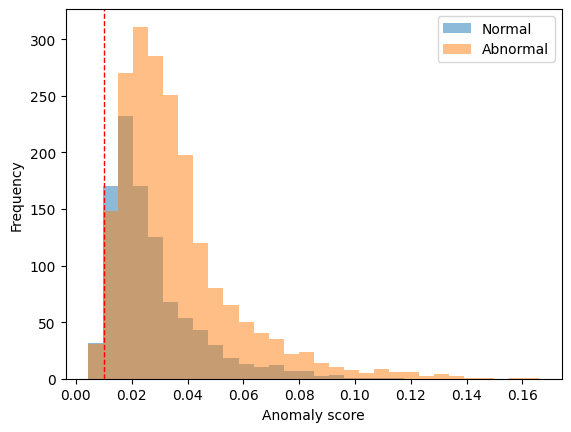

In [ ]:
# Gernerating a plot
arr_label = np.array(dic_loss['label'])
arr_score = np.array(dic_loss['score'])
score_min = arr_score.min()
score_max = arr_score.max()
plt.hist(arr_score[np.where(arr_label == 1)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Normal')
plt.hist(arr_score[np.where(arr_label == 0)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Abnormal')
plt.xlabel("Anomaly score")
plt.ylabel("Frequency")
plt.axvline(THRESHOLDVAL,0,1, color='red',linestyle='--',linewidth=1)
plt.legend(loc='upper right')
plt.savefig("plot.png")
plt.show()

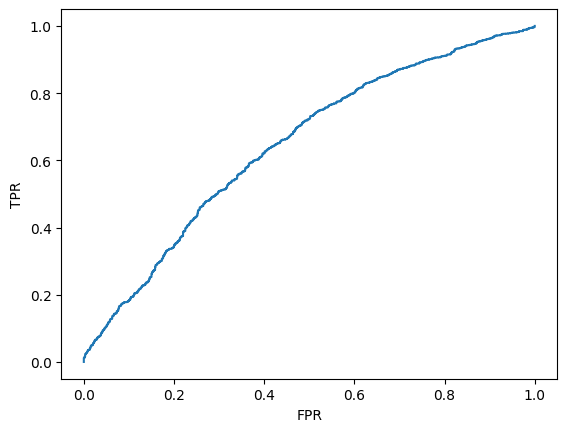

AUROC: 0.6455645


In [ ]:
# Generating AUROC
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
fpr, tpr, thresholds = roc_curve(dic_loss['label'], dic_loss['score'], pos_label=0)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("auroc.png")
plt.show()
auroc = auc(fpr, tpr)
print("AUROC: {}".format(auroc))

In [ ]:
# Leveraging the pandas library to convert a dict to a dataframe is more convenient when checking values.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html
df = pd.DataFrame.from_dict(dic_loss)
df 

,id,label,score,normal
0,0,1,0.038052,0
1,1,0,0.028780,0
2,2,0,0.036060,0
3,3,0,0.032395,0
4,4,0,0.021613,0
...,...,...,...,...
2995,2995,0,0.019570,0
2996,2996,0,0.043783,0
2997,2997,1,0.055789,0
2998,2998,0,0.041545,0


In [ ]:
# In order to submit .csv file to kaggle, dataframe should fit following format
# id[1,2,3...,3000], predicted anomalies[0,1,0....,0]

# 'pop('score,None')' delete one of the item in dict
# 'del df['item']', is also available.

# If you try to remove invalid itmes in the dict, message that you set will be returned.
# set to None, nothing will be returned
dic_loss.pop('score',None)
dic_loss.pop('label',None)
df = pd.DataFrame.from_dict(dic_loss)
df

,id,normal
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2995,2995,0
2996,2996,0
2997,2997,0
2998,2998,0


In [ ]:
# to_csv command will convert your dict to .csv file with the name of your teamnumber
# Do not forget to submit the .csv file to kaggle. If you upload .csv file properly to kaggle, you can check your result immediately at the leaderboard.
teamnumber = 8 # insert your teamnumber
df.to_csv("result_team{}.csv".format(teamnumber), index =False) # Index should be not included in the .csv file.
torch.save(autoencoder.state_dict(), 'model_team{}.pth'.format(teamnumber))